In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram
from neuropy.io.usvio import detect_tone

from tracefc.io.session_directory import get_session_dir

In [2]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [16]:
animal, sess_name = 'Rey', 'recall7'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Rey/2022_05_16_recall7/Rey_recall7_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [17]:
print(sess.eegfile)

duration: 3583.45 seconds 
duration: 1.00 hours 



In [18]:
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Time since rec start (sec)"] = (sync_df['Datetime'] - sync_df.loc[0, 'Datetime']).dt.total_seconds()
sync_df

start time = 2022-05-16 12:24:53.910502-04:00
start time = 2022-05-16 12:41:19.270987-04:00
start time = 2022-05-16 12:48:18.951059-04:00
start time = 2022-05-16 13:11:17.263694-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time,Time since rec start (sec)
0,0,2022-05-16 12:24:53.910502-04:00,start,0,0.000000,0,0.0000,0.000000
1,0,2022-05-16 12:40:47.928602-04:00,stop,28620543,954.018100,1192522,954.0176,954.018100
2,1,2022-05-16 12:41:19.270987-04:00,start,28620544,954.018133,1192523,954.0184,985.360485
3,1,2022-05-16 12:45:35.356287-04:00,stop,36303103,1210.103433,1512629,1210.1032,1241.445785
4,2,2022-05-16 12:48:18.951059-04:00,start,36303104,1210.103467,1512630,1210.1040,1405.040557
5,2,2022-05-16 13:09:00.064625667-04:00,stop,73536511,2451.217033,3064021,2451.2168,2646.154124
6,3,2022-05-16 13:11:17.263694-04:00,start,73536512,2451.217067,3064022,2451.2176,2783.353192
7,3,2022-05-16 13:30:09.491927333-04:00,stop,107503359,3583.445300,4479306,3583.4448,3915.581425


In [19]:
import neuropy.io.miniscopeio as miniio
mini = miniio.MiniscopeIO(sess.basepath)

In [20]:
mini.load_all_orientation()
mini.load_all_timestamps()

including folder /data2/Trace_FC/Recording_Rats/Rey/2022_05_16_recall7/1_tone_recall_novel2/tone_recall/Rey/gobears/2022_05_16/12_27_05
including folder /data2/Trace_FC/Recording_Rats/Rey/2022_05_16_recall7/2_control_tone_recall_novel1/control_tone_recall/Rey/gobears/2022_05_16/12_49_24
including folder /data2/Trace_FC/Recording_Rats/Rey/2022_05_16_recall7/3_ctx_recall/ctx_recall/Rey/gobears/2022_05_16/13_12_40


,Frame Number,Time Stamp (ms),Buffer Index,Timestamps
0,0,-3,0,2022-05-16 12:27:05.873
1,1,86,0,2022-05-16 12:27:05.962
2,2,129,0,2022-05-16 12:27:06.005
3,3,195,0,2022-05-16 12:27:06.071
4,4,263,0,2022-05-16 12:27:06.139
...,...,...,...,...
14696,14696,990128,0,2022-05-16 13:29:10.774
14697,14697,990195,0,2022-05-16 13:29:10.841
14698,14698,990262,0,2022-05-16 13:29:10.908
14699,14699,990330,0,2022-05-16 13:29:10.976


In [21]:
rough_headsensor_times = (mini.orient_all["Timestamps"].dt.tz_localize(tz="America/Detroit") - sync_df.loc[0, "Datetime"]).dt.total_seconds()
mini.orient_all["Rough eeg time (s)"] = rough_headsensor_times
mini.orient_all

,Time Stamp (ms),qw,qx,qy,qz,Timestamps,roll,pitch,yaw,Rough eeg time (s)
0,-3,0.461060,-0.027344,-0.085938,-0.882813,2022-05-16 12:27:05.873,0.127909,-0.127858,-2.187251,131.962498
1,86,0.408081,-0.021729,-0.105652,-0.906555,2022-05-16 12:27:05.962,0.176122,-0.125957,-2.306784,132.051498
2,129,0.409607,-0.023865,-0.076172,-0.908752,2022-05-16 12:27:06.005,0.119850,-0.105977,-2.301011,132.094498
3,195,0.438599,-0.012207,-0.087097,-0.894348,2022-05-16 12:27:06.071,0.146309,-0.098401,-2.236884,132.160498
4,263,0.464661,0.000000,-0.066223,-0.882996,2022-05-16 12:27:06.139,0.117441,-0.061584,-2.176370,132.228498
...,...,...,...,...,...,...,...,...,...,...
14696,990128,0.832825,0.341370,0.056702,-0.432068,2022-05-16 13:29:10.774,0.599388,0.400014,-0.832046,3856.863498
14697,990195,0.818848,0.368042,0.066894,-0.435364,2022-05-16 13:29:10.841,0.647390,0.444515,-0.825979,3856.930498
14698,990262,0.804688,0.413696,0.054260,-0.422424,2022-05-16 13:29:10.908,0.760342,0.452068,-0.783571,3856.997498
14699,990330,0.791626,0.439819,0.006348,-0.424072,2022-05-16 13:29:10.976,0.845084,0.393130,-0.804990,3857.065498


In [22]:
rough_headsensor_times = (mini.orient_all["Timestamps"].dt.tz_localize(tz="America/Detroit") - sync_df.loc[0, "Datetime"]).dt.total_seconds()
mini.orient_all["Time from OE start"] = rough_headsensor_times
mini.orient_all

# Key line of code - converts miniscope time (which doesn't account for disconnects) to eeg time (which cuts out disconnect times)
mini.orient_all["Rough eeg time (s)"] = np.interp(mini.orient_all["Time from OE start"], sync_df["Time since rec start (sec)"], 
                                            sync_df["eeg_time"])
mini.orient_all

,Time Stamp (ms),qw,qx,qy,qz,Timestamps,roll,pitch,yaw,Rough eeg time (s),Time from OE start
0,-3,0.461060,-0.027344,-0.085938,-0.882813,2022-05-16 12:27:05.873,0.127909,-0.127858,-2.187251,131.962429,131.962498
1,86,0.408081,-0.021729,-0.105652,-0.906555,2022-05-16 12:27:05.962,0.176122,-0.125957,-2.306784,132.051429,132.051498
2,129,0.409607,-0.023865,-0.076172,-0.908752,2022-05-16 12:27:06.005,0.119850,-0.105977,-2.301011,132.094429,132.094498
3,195,0.438599,-0.012207,-0.087097,-0.894348,2022-05-16 12:27:06.071,0.146309,-0.098401,-2.236884,132.160429,132.160498
4,263,0.464661,0.000000,-0.066223,-0.882996,2022-05-16 12:27:06.139,0.117441,-0.061584,-2.176370,132.228429,132.228498
...,...,...,...,...,...,...,...,...,...,...,...
14696,990128,0.832825,0.341370,0.056702,-0.432068,2022-05-16 13:29:10.774,0.599388,0.400014,-0.832046,3524.726926,3856.863498
14697,990195,0.818848,0.368042,0.066894,-0.435364,2022-05-16 13:29:10.841,0.647390,0.444515,-0.825979,3524.793926,3856.930498
14698,990262,0.804688,0.413696,0.054260,-0.422424,2022-05-16 13:29:10.908,0.760342,0.452068,-0.783571,3524.860926,3856.997498
14699,990330,0.791626,0.439819,0.006348,-0.424072,2022-05-16 13:29:10.976,0.845084,0.393130,-0.804990,3524.928926,3857.065498


In [23]:
cs_epochs_file = sess.filePrefix.with_suffix(".cs_epochs.npy")
sess.cs_epochs = Epoch(epochs=None, file=cs_epochs_file)
sess.cs_epochs.starts

array([ 193.220926,  258.445248,  323.701013,  384.919774,  452.15536 ,
        530.484835,  590.713938,  660.980891,  741.305659,  804.551656,
        877.820033,  995.066801, 1063.307494, 1124.523763])

In [24]:
csn_epochs_file = sess.filePrefix.with_suffix(".csn_epochs.npy")
sess.csn_epochs = Epoch(epochs=None, file=csn_epochs_file)
sess.csn_epochs.starts

array([1337.148105, 1407.399088, 1476.677379, 1550.982829, 1623.247571,
       1687.498701, 1752.736997, 1832.040662, 1892.254293, 1972.592538,
       2039.827622, 2100.055725])

In [25]:
cs2_epochs_file = sess.filePrefix.with_suffix(".cs2_epochs.npy")
sess.cs2_epochs = Epoch(epochs=None, file=cs2_epochs_file)
sess.cs2_epochs.starts

array([2177.378571, 2248.636683, 2321.936002])

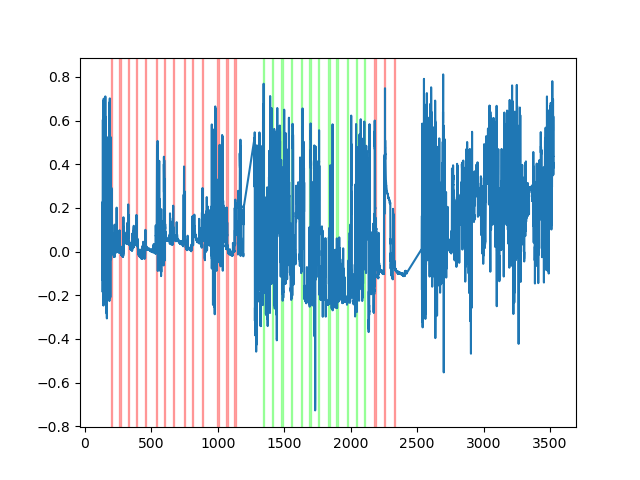

In [26]:
%matplotlib widget
_, ax = plt.subplots()
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.pitch)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

In [27]:
def calc_head_speed(df):

    angle_diffs = []
    for ang_axis in ["roll", "pitch", "yaw"]:
        axis_diff = df[ang_axis].diff()

        # Correct any swings of > 2*pi
        axis_diff[axis_diff > 1.8 * np.pi] = axis_diff[axis_diff > 1.8 * np.pi] - 2 * np.pi
        axis_diff[axis_diff < -1.8 * np.pi] = axis_diff[axis_diff < -1.8 * np.pi] + 2 * np.pi
        angle_diffs.append(axis_diff.values)
    # head_speed = np.sqrt(np.square(df.roll.diff()) + np.square(df.pitch.diff()) + np.square(df.yaw.diff())) / df["Rough eeg time (s)"].diff()
    head_speed = np.sqrt(np.square(angle_diffs[0]) + np.square(angle_diffs[1]) + np.square(angle_diffs[2]))
    return head_speed
calc_head_speed(mini.orient_all)

array([       nan, 0.12890405, 0.05999211, ..., 0.12088701, 0.10542154,
       0.08939294])

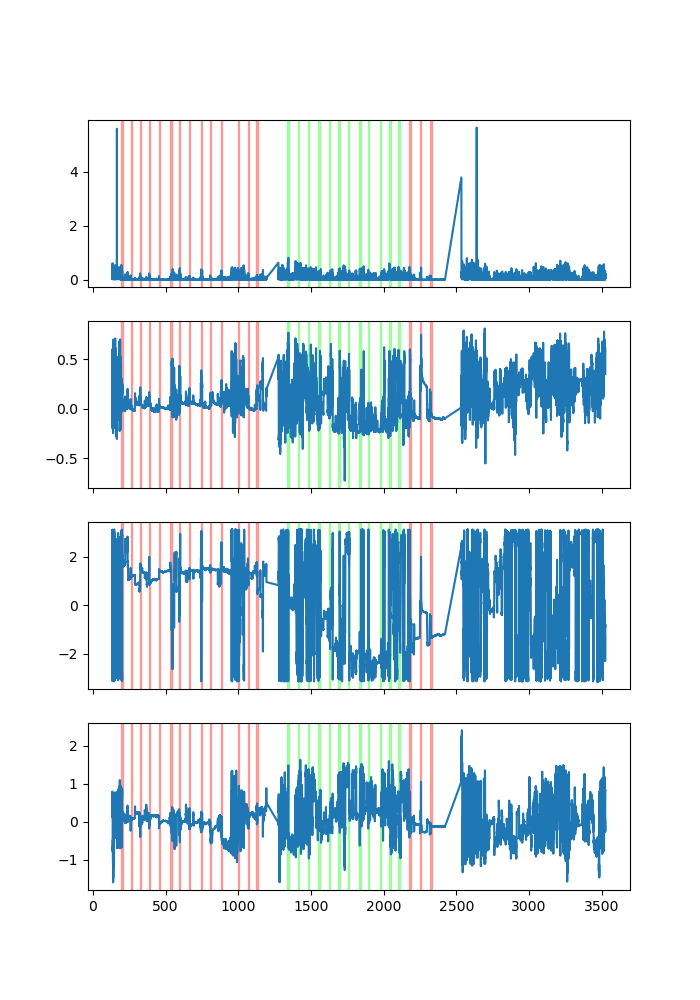

In [28]:
%matplotlib widget
_, axs = plt.subplots(4, 1, figsize=(7, 10), sharex=True)
ax = axs[0]
mini.orient_all["Head speed"] = calc_head_speed(mini.orient_all)
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all["Head speed"])
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

ax = axs[1]
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.pitch)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

ax = axs[2]
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.yaw)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

ax = axs[3]
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.roll)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

In [29]:
import neuropy.io.dlcio as dlcio
dlc_path = '/data3/Trace_FC/Recording_Rats/Finn2/2023_05_09_recall1'
arena_side_pix = 60  # Keep this
arena_side_cm = 25.4  # Update this after measuring!!!
pix2cm = arena_side_cm / arena_side_pix

# Read in DLC data
sess.dlc = dlcio.DLC(dlc_path, pix2cm=pix2cm)

# Smooth position, get timestamps, and get speed
sess.dlc.get_timestamps('ms_webcam', include_str="1_tone_recall")
sess.dlc.smooth_pos(bodyparts=["crown_middle", "back_middle"])
sess.dlc.timestamps["Timestamps"] = sess.dlc.timestamps["Timestamps"].dt.tz_localize("America/Detroit")
sess.dlc.get_all_speed()

ValueError: No objects to concatenate

In [26]:
# Load in openephys times to sync
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Total seconds from start"] = (sync_df["Datetime"] - sync_df["Datetime"][0]).dt.total_seconds()

# sync DLC times to your eeg file
sess.dlc.timestamps["Total seconds from OE start"] = (sess.dlc.timestamps["Timestamps"] - sync_df["Datetime"][0]).dt.total_seconds()
sess.dlc.timestamps["eeg_time"] = np.interp(sess.dlc.timestamps["Total seconds from OE start"], sync_df["Total seconds from start"], 
                                            sync_df["eeg_time"])
sess.dlc.timestamps

start time = 2022-05-10 12:13:38.509808-04:00
start time = 2022-05-10 12:41:36.079634-04:00
start time = 2022-05-10 12:47:45.639612-04:00
start time = 2022-05-10 13:04:55.897736-04:00


AttributeError: 'ProcessData' object has no attribute 'dlc'

In [27]:
# Last calculate freezing times and plot again to check
frz_thresh = 0.25 # cm/sec  Adjust this to something that looks reasonable!
duration_thresh = 1 # sec, must be below the threshold above for at least that long to be considered freezing
bodypart_use = "crown_middle"
frz_bool = sess.dlc.speed[bodypart_use] < frz_thresh
frz_epochs = Epoch.from_boolean_array(frz_bool, t=sess.dlc.timestamps["eeg_time"])
frz_df = frz_epochs.to_dataframe()
frz_df = frz_df[frz_epochs.durations > duration_thresh]
frz_epochs = Epoch(frz_df)
frz_epochs

AttributeError: 'ProcessData' object has no attribute 'dlc'

AttributeError: 'ProcessData' object has no attribute 'dlc'

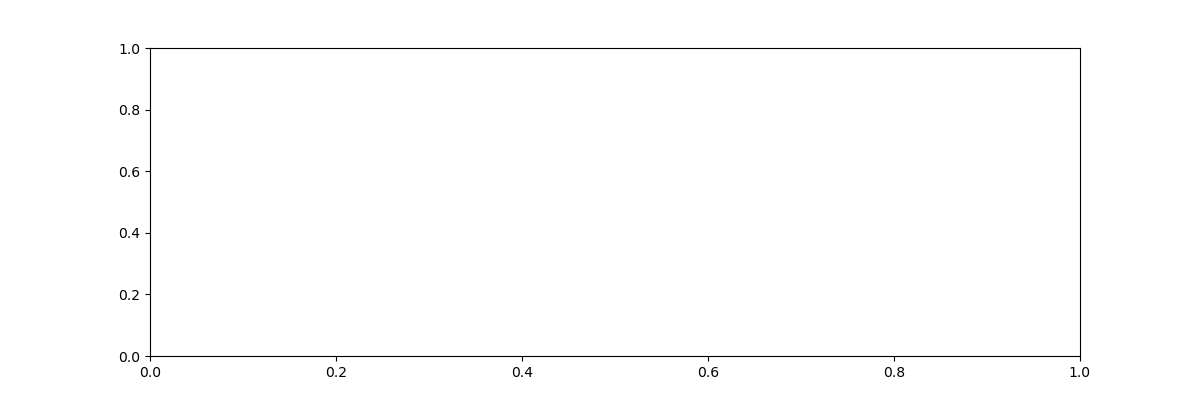

In [28]:
%matplotlib widget
# Plot to check! Looks ok, though there might be some mismatches between theta and movement.

_, ax = plt.subplots(figsize=(12, 4))
hc, = ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.speed["crown_middle"])
hb, = ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.speed["back_middle"])
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5])

# Now plot theta epochs over it to triple check!
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start = sess.dlc.timestamps["eeg_time"].min(), t_stop=sess.dlc.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])

ax.legend((hc, hb, hthresh, htheta, hf), ("crown_middle", "back_middle", "freeze threshold", "theta", "frz"))

#### Double check start time

,channel_states,timestamps,datetimes,event_name


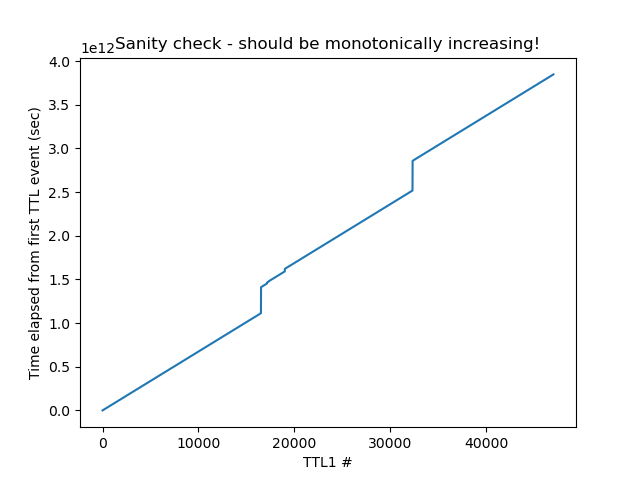

In [29]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [30]:
accurate_start_time = ttl_df[ttl_df['channel_states'].abs() == 1].iloc[6355]['datetimes']
accurate_start_time = accurate_start_time.tz_localize('America/Detroit')

In [31]:
approx_start_time = sess.dlc.timestamps.loc[0, 'Timestamps']
approx_start_time

AttributeError: 'ProcessData' object has no attribute 'dlc'

In [32]:
adj_time_delta = (accurate_start_time - approx_start_time).total_seconds()
adj_time_delta

NameError: name 'approx_start_time' is not defined

In [ ]:
sess.dlc.timestamps.head(1)

In [ ]:
# Try manually adjusting times in DLC data and see if it matches better!
from copy import deepcopy
dlcadj = deepcopy(sess.dlc)

dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + adj_time_delta

_, axcomb = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
ax = axcomb[0]
hc, = ax.plot(dlcadj.timestamps["eeg_time"], dlcadj.speed["crown_middle"])
hb, = ax.plot(dlcadj.timestamps["eeg_time"], dlcadj.speed["back_middle"])
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5])

# Now plot theta epochs over it to triple check!
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start = dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])

ax.legend((hc, hb, hthresh, htheta, hf), ("crown_middle", "back_middle", "freeze threshold", "theta", "frz"))
# ax.set_xlim((2535, 2565))

plot_signal_w_epochs(signal, 28, art_epochs, ax=axcomb[1])

In [9]:
# Try manually adjusting times in DLC data and see if it matches better!
from copy import deepcopy
manually_adjust_dlc_times = -0.528  # seconds
dlcadj = deepcopy(sess.dlc)

dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))

hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):

    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5])

# Now plot theta epochs over it to triple check!
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start = dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])

ax.legend((hc, hb, hthresh, htheta, hf), ("crown_middle", "back_middle", "freeze threshold", "theta", "frz"))
# ax.set_xlim((2535, 2565))

AttributeError: 'ProcessData' object has no attribute 'dlc'

In [10]:
#Freezing and theta
from copy import deepcopy

manually_adjust_dlc_times = -0.528  
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 4:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs = Epoch(epochs=None, file=beta_epochs_file)
beta_epochs = beta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5], label='theta')
    
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())


AttributeError: 'ProcessData' object has no attribute 'dlc'

In [11]:
#Freezing and ripple
from copy import deepcopy

manually_adjust_dlc_times = -0.528  
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 4:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs = Epoch(epochs=None, file=ripple_epochs_file)
ripple_epochs = ripple_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs = Epoch(epochs=None, file=beta_epochs_file)
beta_epochs = beta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

for start, stop in zip(ripple_epochs.starts, ripple_epochs.stops):
    hripple = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5], label='ripple')
    
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())


AttributeError: 'ProcessData' object has no attribute 'dlc'

In [12]:
#Freezing and ripple
from copy import deepcopy
import matplotlib.pyplot as plt

# Assuming sess, frz_thresh, frz_epochs, and other necessary variables are defined elsewhere

manually_adjust_dlc_times = -0.528  
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))

# Use axhline to draw lines for visual separation (optional)
ax.axhline(0.5, color='k', linestyle='-', alpha=0.5)  # Mid-line for visual separation

# Plot freezing events below the line
for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    ax.axvspan(start, stop, ymin=0, ymax=0.5, color=[0.3, 0, 0, 0.5], label='frz')

# Plot ripple events above the line
for start, stop in zip(ripple_epochs.starts, ripple_epochs.stops):
    ax.axvspan(start, stop, ymin=0.5, ymax=1, color=[0, 0.3, 0, 0.5], label='ripple')

# Adjust the y-axis to hide the y-ticks and labels as they don't represent meaningful values in this context
ax.set_yticks([])
ax.set_ylabel("Events")

# Handle legend to avoid duplicate labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

AttributeError: 'ProcessData' object has no attribute 'dlc'

In [13]:
#Freezing and beta
from copy import deepcopy

manually_adjust_dlc_times = -0.528
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 4:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs = Epoch(epochs=None, file=beta_epochs_file)
beta_epochs = beta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())


    
for start, stop in zip(beta_epochs.starts, beta_epochs.stops):
    hbeta = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.5], label='beta')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

AttributeError: 'ProcessData' object has no attribute 'dlc'

In [14]:
#Freezing and gamma  Gamma detection is wrong?
from copy import deepcopy

manually_adjust_dlc_times = -0.528 
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 4:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

gamma_epochs_file = sess.filePrefix.with_suffix(".gamma_epochs.npy")
gamma_epochs = Epoch(epochs=None, file=gamma_epochs_file)
gamma_epochs = gamma_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())


    
for start, stop in zip(gamma_epochs.starts, gamma_epochs.stops):
    hgamma = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.5], label='gamma')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

AttributeError: 'ProcessData' object has no attribute 'dlc'

In [15]:
#Freezing and delta
from copy import deepcopy

manually_adjust_dlc_times = -0.528 
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 4:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

# theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
# theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
# theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
delta_epochs = Epoch(epochs=None, file=delta_epochs_file)
delta_epochs = delta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())


    
for start, stop in zip(delta_epochs.starts, delta_epochs.stops):
    duration = stop-start
    if duration>0.2:
        hdelta = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.5], label='delta')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

AttributeError: 'ProcessData' object has no attribute 'dlc'

In [16]:
#Freezing and USV
from copy import deepcopy

manually_adjust_dlc_times = -0.528 
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

# theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
# theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
# theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs


# delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
# delta_epochs = Epoch(epochs=None, file=delta_epochs_file)
# delta_epochs = delta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())


    
for start, stop in zip(usv_epochs.starts, usv_epochs.stops):
    duration = stop-start

    husv = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.5], label='usv')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

AttributeError: 'ProcessData' object has no attribute 'dlc'

## Save notebook to animal working directory

In [17]:
from neuropy.utils.manipulate_files import save_notebook
try:
    save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")
except PermissionError:
    print('Got a weird PermissionError. Check to make sure file saved successfully')

/data/GitHub/TraceFC/Notebooks/Animal_files/Recall1 Notebooks/Sync_USV_and_Ephys(Rey).ipynb saved to /data2/Trace_FC/Recording_Rats/Rey/2022_05_10_recall1/Rey_recall1_Sync_USV_and_Ephys(Rey).ipynb


### Load in disconnect and motion artifacts

In [ ]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

In [ ]:
%matplotlib widget

chan_plot = 28
plot_signal_w_epochs(signal, 28, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Jyn/2022_06_18_recall1/Jyn_recall1_denoised.probegroup.npy saved


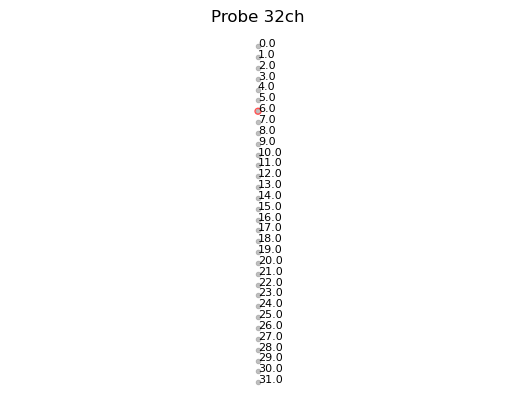

In [13]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect delta epochs

In [38]:
#Detect Delta
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
freq_band = (0.5, 4)
min_dur = 0.15  
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 59  

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal
delta_epochs = detect_hpc_delta_wave_epochs(
    signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
)

ValueError: 59 is not in list

## Detect Beta epochs

In [39]:
#Detect Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 59
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

ValueError: 59 is not in list

## Detect Theta epochs

In [40]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 59

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

ValueError: 59 is not in list

## Detect SWR Epochs

In [41]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 59
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


ValueError: 59 is not in list

## Detect gamma epochs

In [42]:
125/1250

0.1

In [43]:
# Detect Gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 1.5  
highthresh = 3 
minDistance = 300
minDuration = 125
gamma_channel = 59

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
# gammadetect.get_peak_intervals(signal.traces, lowthresh=lowthresh, highthresh=highthresh, minDistance=minDistance, minDuration=minDuration)
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
# csd=csd(self, period, refchan, band=band, window=1250)
gamma_epochs = Epoch(pd.DataFrame({"start" : peakevents[:, 0]/sess.eegfile.sampling_rate, "stop": peakevents[:, 1]/sess.eegfile.sampling_rate,
                   "label": ""}))
# pd.DataFrame(dict(start=peakevents[:, 0]/sess.eegfile.sampling_rate, stop=peakevents[:, 1]/sess.eegfile.sampling_rate))

IndexError: index 59 is out of bounds for axis 0 with size 35

In [44]:
gamma_epochs

NameError: name 'gamma_epochs' is not defined

In [45]:
np.arange(0, len(gamma_amp))/sess.eegfile.sampling_rate 

NameError: name 'gamma_amp' is not defined

NameError: name 'gamma_epochs' is not defined

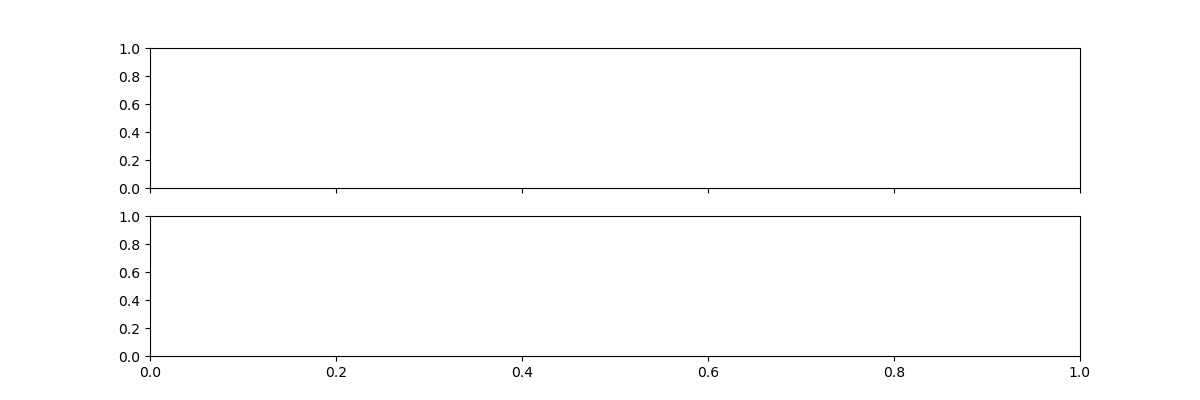

In [46]:
import scipy.stats as stats
_, ax = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
plot_signal_w_epochs(signal, gamma_channel, gamma_epochs, ax=ax[0])
ax[1].plot(np.arange(0, len(gamma_amp))/sess.eegfile.sampling_rate , stats.zscore(gamma_amp))

## Sync via CS+ or CS- times in tone_recall or control_tone_recall or tone_habituation session

,channel_states,timestamps,datetimes,event_name
915,2,5920254,2023-05-09 12:17:50.341800000,
1063,-2,6217851,2023-05-09 12:18:00.261700000,
1862,2,7831319,2023-05-09 12:18:54.043966667,
2011,-2,8129436,2023-05-09 12:19:03.981200000,
2870,2,9864601,2023-05-09 12:20:01.820033333,


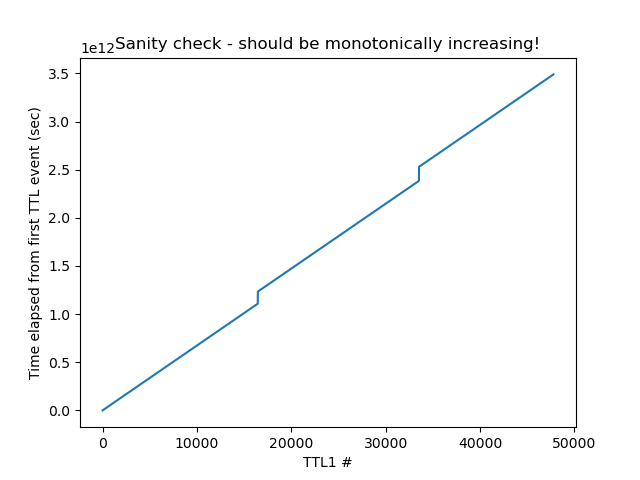

In [47]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [48]:
import tracefc.io.traceio as traceio

if "training" in str(sess.basepath):
    # For tone habituation
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))
    
    # For CS+ during training
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
elif "recall" in str(sess.basepath):
    # For tone recall CS+
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))

15 CS+ events detected
      Time (s)      Event                     Timestamp
5    61.734383  CS1_start 2023-05-09 12:17:50.975583106
7   125.436887  CS2_start 2023-05-09 12:18:54.678087026
9   193.213021  CS3_start 2023-05-09 12:20:02.454221040
11  256.929908  CS4_start 2023-05-09 12:21:06.171107560
13  330.764161  CS5_start 2023-05-09 12:22:20.005360872
15  394.481047  CS6_start 2023-05-09 12:23:23.722247153
12 CS- events detected
      Time (s)      Event                     Timestamp
5    61.624768  CS1_start 2023-05-09 12:38:24.051703780
7   131.415150  CS2_start 2023-05-09 12:39:33.842086404
9   199.191781  CS3_start 2023-05-09 12:40:41.618716806
11  262.909666  CS4_start 2023-05-09 12:41:45.336602061
13  332.700054  CS5_start 2023-05-09 12:42:55.126990407
15  411.639126  CS6_start 2023-05-09 12:44:14.066062062


In [49]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2023-05-09 12:14:33-04:00
start time = 2023-05-09 12:35:50-04:00
start time = 2023-05-09 12:57:20-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2023-05-09 12:14:33-04:00,start,0,0.000000,0,0.0000
1,0,2023-05-09 12:35:26.794100-04:00,stop,37613823,1253.794100,1567242,1253.7936
2,1,2023-05-09 12:35:50-04:00,start,37613824,1253.794133,1567243,1253.7944
3,1,2023-05-09 12:57:05.383433333-04:00,stop,75875327,2529.177567,3161471,2529.1768
4,2,2023-05-09 12:57:20-04:00,start,75875328,2529.177600,3161472,2529.1776
5,2,2023-05-09 13:15:09.764233333-04:00,stop,107968255,3598.941833,4498677,3598.9416


In [50]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = pd.Timedelta(0.8, unit="seconds")
cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
cs_oe_stop_df = traceio.trace_ttl_to_openephys(cs_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)
cs_stops_combined = oeio.recording_events_to_combined_time(cs_oe_stop_df, sync_df)

csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)
csn_oe_stop_df = traceio.trace_ttl_to_openephys(csn_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

start time lag: mean = -0.6353362643999999, std = 0.0009445403231395352
start time lag: mean = -0.6358434884666667, std = 0.0008962459542547397
start time lag: mean = -0.49114653991666674, std = 0.0007334556383254259
start time lag: mean = -0.4915446435, std = 0.0007799921842718524


/data/GitHub/TraceFC/tracefc/io/traceio.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace_cs_sync_df.loc[:, "datetimes"] = trace_cs_sync_df["datetimes"].dt.tz_localize(


In [51]:
cs_starts

,Time (s),Event,Timestamp
5,61.734383,CS1_start,2023-05-09 12:17:50.975583106
7,125.436887,CS2_start,2023-05-09 12:18:54.678087026
9,193.213021,CS3_start,2023-05-09 12:20:02.454221040
11,256.929908,CS4_start,2023-05-09 12:21:06.171107560
13,330.764161,CS5_start,2023-05-09 12:22:20.005360872
15,394.481047,CS6_start,2023-05-09 12:23:23.722247153
17,464.287302,CS7_start,2023-05-09 12:24:33.528501540
19,525.944309,CS8_start,2023-05-09 12:25:35.185509473
21,602.853748,CS9_start,2023-05-09 12:26:52.094948322
23,675.704437,CS10_start,2023-05-09 12:28:04.945637494


In [52]:
cs_oe_start_df

,channel_states,timestamps,datetimes,event_name
915,2,5920254,2023-05-09 12:17:50.341800-04:00,
1862,2,7831319,2023-05-09 12:18:54.043966667-04:00,
2870,2,9864601,2023-05-09 12:20:01.820033333-04:00,
3818,2,11776103,2023-05-09 12:21:05.536766667-04:00,
4916,2,13991117,2023-05-09 12:22:19.370566667-04:00,
5863,2,15902618,2023-05-09 12:23:23.087266667-04:00,
6901,2,17996798,2023-05-09 12:24:32.893266667-04:00,
7818,2,19846505,2023-05-09 12:25:34.550166667-04:00,
8962,2,22153780,2023-05-09 12:26:51.459333333-04:00,
10045,2,24339295,2023-05-09 12:28:04.309833333-04:00,


### How to write CS+ to neuroscope event file

In [53]:
cs_tone_recall_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ["CS+"]*len(cs_starts_combined)})
cs_tone_recall_epochs
sess.recinfo.write_epochs(cs_tone_recall_epochs, "cs+")

In [54]:
cs_tone_recall_epochs

15 epochs
Snippet: 
         start        stop label
0  197.341800  207.261700   CS+
1  261.043966  270.981200   CS+
2  328.820033  338.760733   CS+
3  392.536766  402.450266   CS+
4  466.370566  476.309700   CS+

In [55]:
sess_use

<function __main__.sess_use(basepath='/data/GitHub/TraceFC/Notebooks/Animal_files/Recall1 Notebooks')>

In [56]:
from tracefc.io.traceio import grab_usv_folder
csp_wav = grab_usv_folder(sess.basepath, 'csp')
print(csp_wav)
# Get CS+ times and plot to check
cs_wav_epochs = detect_tone(csp_wav, freq_lims=(6900, 7100), thresh=0.05, tone_length=10, tone_label="CS+", plot_check=True)
# Check that lags are consistent
if (animal == 'Django') & (sess_name == 'training'):
    cs_starts_combined = cs_starts_combined[:5]
    cs_stops_combined = cs_stops_combined[:5]
cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

None


TypeError: Invalid file: None

Ditto for CS-

In [ ]:
# Detect CS- in audio recording.
csn_wav = grab_usv_folder(sess.basepath, "csn")
print(csn_wav)

# Get CS+ times and plot to check
csn_wav_epochs, csn_wav_stop = detect_tone(csn_wav, freq_lims=(900, 1100), thresh=-0.1, tone_length=10, tone_label="CS-", 
                                           plot_check=True, return_stop=True)

# Check that lags are consistent
csn_start_lags = csn_starts_combined - csn_wav_epochs.starts
print(f"Mean start lag time of {np.mean(csn_start_lags):0.3F} sec with std = {np.std(csn_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
csn_stop_lags = csn_stops_combined - csn_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(csn_stop_lags):0.3F} sec with std = {np.std(csn_stop_lags):0.3F} sec.")

Now try to sync to start tone 

In [57]:
ctx_recall_wav = sorted((sess.basepath / "3_post").glob("**/*.wav"))[0]
print(ctx_recall_wav)

# Get CS+ times and plot to check
start_wav_epochs = detect_tone(ctx_recall_wav, freq_lims=(450, 550), thresh=10, tone_length=0.5, tone_label="start_tone", plot_check=True)

IndexError: list index out of range

## Sync recorded USV times to ephys file

In [48]:
# Read in USV times from tone recall session
from neuropy.io.usvio import DeepSqueakIO
csp_wav = Path(csp_wav)
usv_detect_file = sorted(csp_wav.parent.glob(f"**/{csp_wav.name[:-4]}*_cell.mat"))[0]

ds_calls = DeepSqueakIO(filename=usv_detect_file)
ds_calls.load_calls()
ds_calls.usv_df

,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept
0,140.510072,20.250000,0.010000,6.125000,0.512616,0
1,192.947980,20.250000,0.010000,6.000000,0.509522,0
2,479.631519,37.931231,0.082915,25.781799,1.000000,1
3,479.909576,43.574457,0.083752,21.466391,1.000000,1
4,480.406645,41.472079,0.066164,19.585315,1.000000,1
...,...,...,...,...,...,...
296,1615.701863,16.277778,0.442977,7.666667,1.000000,1
297,1616.202034,17.375613,0.411892,7.474265,1.000000,1
298,1616.681566,15.579628,0.423734,9.516029,1.000000,1
299,1617.175167,17.166667,0.523783,7.597036,1.000000,1


Plot lags vs time to check for drift between ephys and audio recordings and correct if necessary

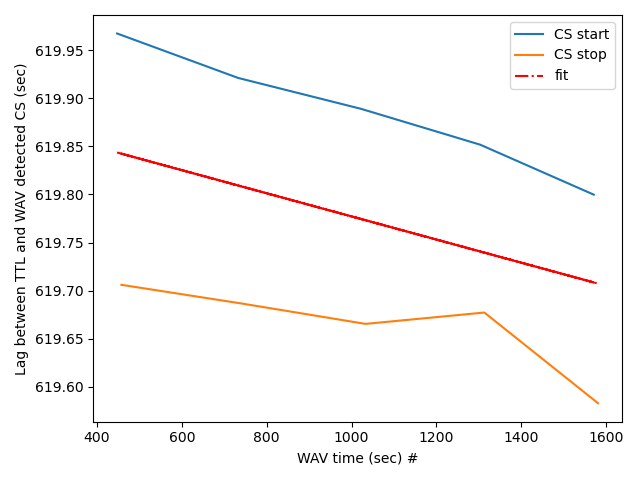

In [49]:
from scipy.linalg import lstsq

_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb)
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
hfit = ax.plot(cs_times_wav.T.reshape(-1), p[0] + p[1]*cs_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [50]:
# Sanity check code to output corrected CS times from WAV file to Neuroscope
cs_wav_starts_aligned = cs_wav_epochs.starts + p[0] + p[1]*cs_wav_epochs.starts
cs_wav_stops_aligned = cs_wav_epochs.stops + p[0] + p[1]*cs_wav_epochs.stops
cs_wav_epochs_aligned = Epoch({"start": cs_wav_starts_aligned, "stop": cs_wav_stops_aligned, 
                               "label": ["CS+ from WAV file"]*len(cs_wav_stops_aligned)})


cs_epochs_files = sess.filePrefix.with_suffix(".cs_wav_epochs.npy")
cs_wav_epochs_aligned.save(cs_epochs_files)
sess.recinfo.write_epochs(cs_wav_epochs_aligned, ext="wv+")

/data3/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_denoised.cs_wav_epochs.npy saved


In [51]:
cs_wav_epochs_aligned

5 epochs
Snippet: 
          start         stop              label
0  1067.204361  1077.383754  CS+ from WAV file
1  1352.267763  1362.436989  CS+ from WAV file
2  1642.406790  1652.561187  CS+ from WAV file
3  1922.404454  1932.493802  CS+ from WAV file
4  2190.223020  2200.374046  CS+ from WAV file

Now correct that drift and find corrected lags!

In [ ]:
# This should eventually be folded into the DeepSqueakIO class!
# Bowen question: 
calls_accept_df = ds_calls.usv_df[ds_calls.usv_df['Accept'] == 1]
call_starts_wav = calls_accept_df['Begin_Time'].values
call_stops_wav = call_starts_wav + calls_accept_df['Duration'].values
calls_accept_df.insert(0, "start", call_starts_wav + p[0] + p[1]*call_starts_wav)
calls_accept_df.insert(1, "stop", call_stops_wav + p[0] + p[1]*call_stops_wav)
calls_accept_df.insert(calls_accept_df.shape[1], "label", "")
good_calls = Epoch(calls_accept_df)

# output to neuroscope and neuropy
sess.recinfo.write_epochs(good_calls, ext="usv")
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
good_calls.save(usv_epochs_file)

In [ ]:
good_calls

## Save notebook to working directory

In [ ]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

### Read in DeepLabCut Data and sync with OpenEphys data